In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

In [ ]:
# Global Variables

# Analisis Exploratorio

In [ ]:
train_data = pd.read_csv('./data/train.csv', encoding = "ISO-8859-1")

### Analizando las variables numericas

In [32]:
quant_col_vars = train_data.describe().columns[1:-1]

36

### Analizando las variables categoricas

### Analizando la variable de interes

In [19]:
#skewness and kurtosis
print('Skewness: %f' % train_data['SalePrice'].skew())
print('Kurtosis: %f' % train_data['SalePrice'].kurt())
print('\n---Describe---')
train_data['SalePrice'].describe()


Skewness: 1.882876
Kurtosis: 6.536282

---Describe---


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

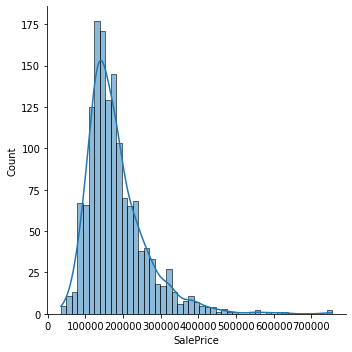

In [21]:
sns.displot(train_data['SalePrice'], kde=True)

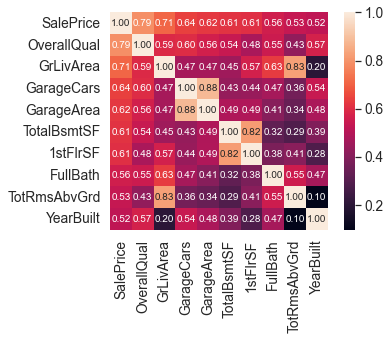

In [22]:
k = 10 #number of variables for heatmap
corrmat = train_data.corr()
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

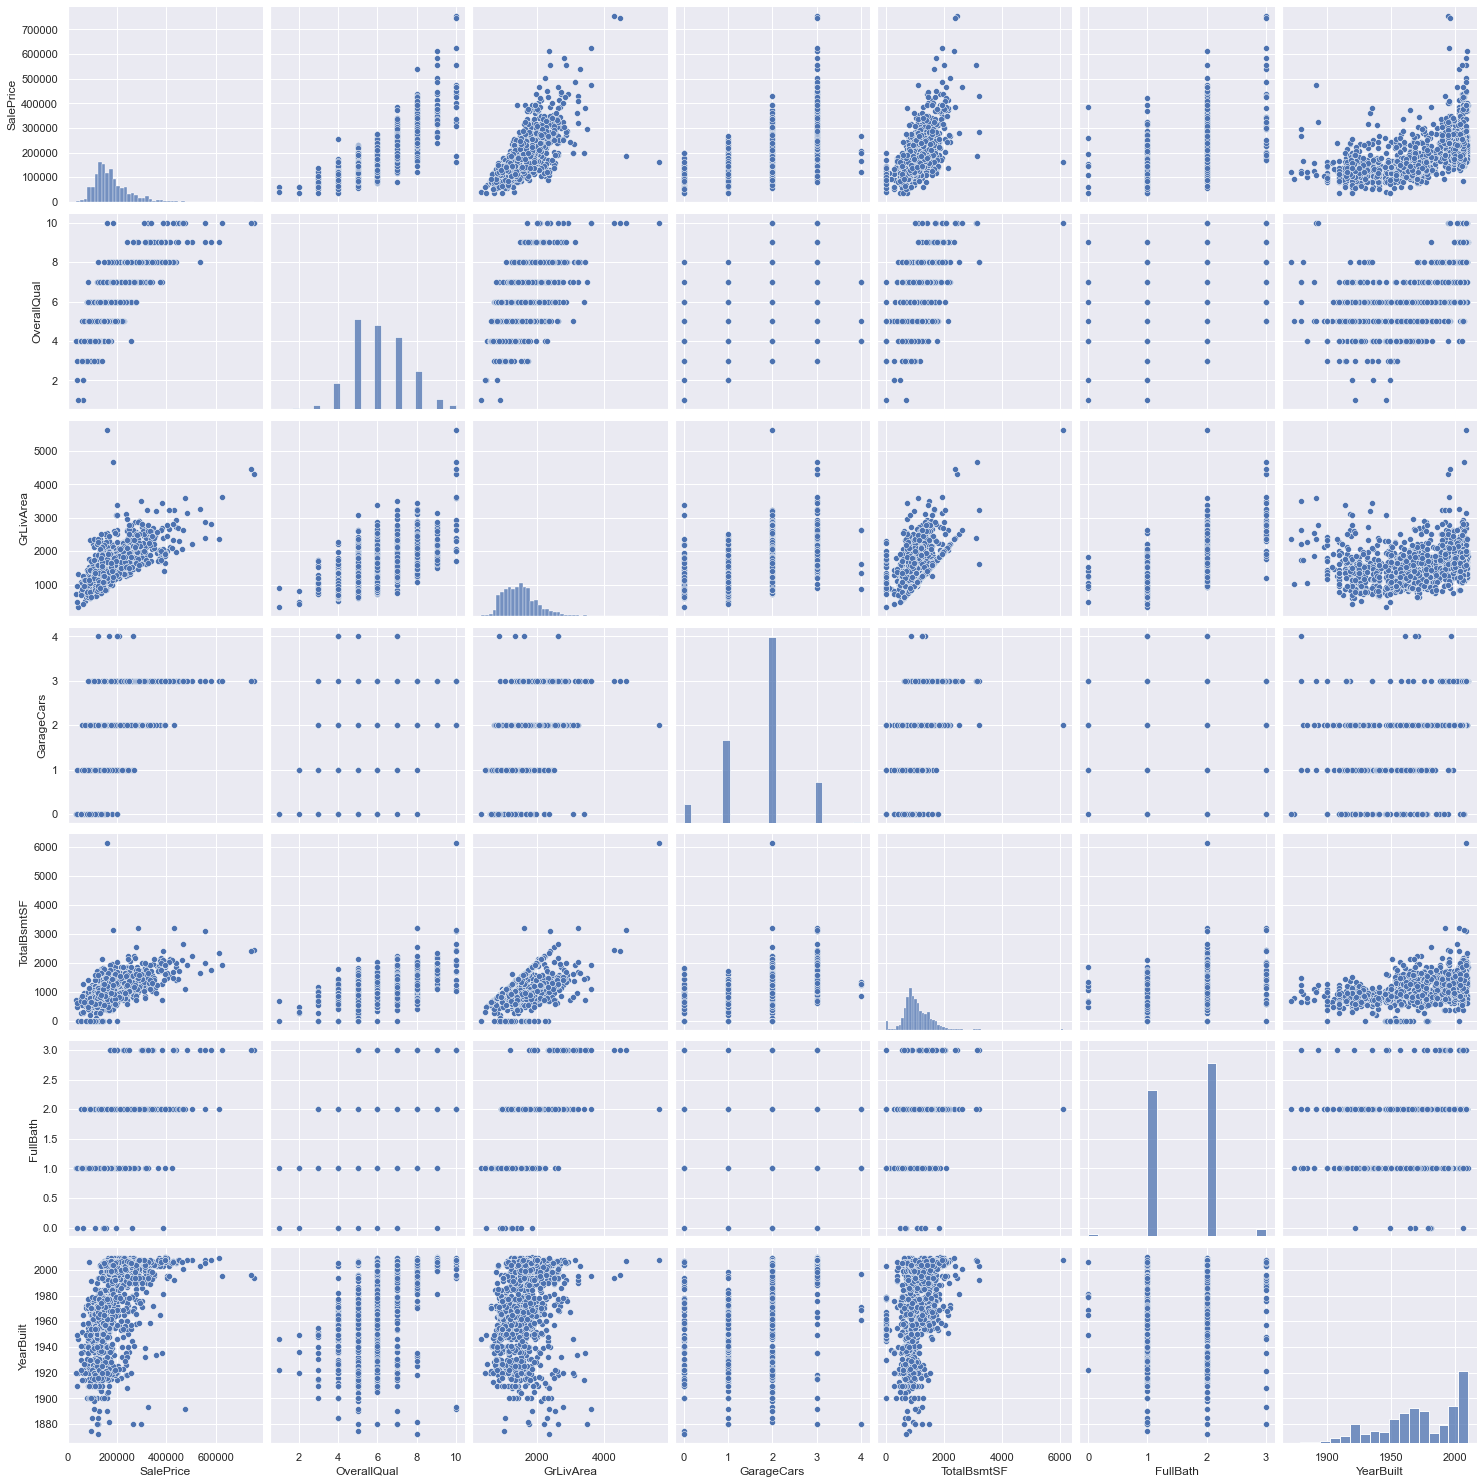

In [26]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train_data[cols], height= 3)
plt.show()